In [1]:
import pandas as pd

# Load the dataset
twitter = pd.read_csv('twitter.csv')
print(f"Original dataset size: {len(twitter)} rows")

# Sample 30,000 data points randomly
twitter = twitter.sample(n=30000, random_state=42)
print(f"Sampled dataset size: {len(twitter)} rows")
print("\nFirst few rows of the sampled data:")
print(twitter.head())

Original dataset size: 14262517 rows
Sampled dataset size: 30000 rows

First few rows of the sampled data:
           longitude   latitude       timestamp  timezone
760122    -79.754563  34.163019  20130112131218         1
5640992  -122.405556  37.746787  20130114191619         4
10841552  -83.433181  38.185017  20130117103154         1
6961607   -84.650231  41.976939  20130115124436         1
593201    -95.997310  47.806276  20130112113944         2
Sampled dataset size: 30000 rows

First few rows of the sampled data:
           longitude   latitude       timestamp  timezone
760122    -79.754563  34.163019  20130112131218         1
5640992  -122.405556  37.746787  20130114191619         4
10841552  -83.433181  38.185017  20130117103154         1
6961607   -84.650231  41.976939  20130115124436         1
593201    -95.997310  47.806276  20130112113944         2


# Exploratory Data Analysis

Let's examine the distribution of timezones and check for any missing values.

In [6]:
# Check data info and missing values
print("Dataset Info:")
print(twitter.info())
print("\nMissing values:")
print(twitter.isnull().sum())
print("\nTimezone distribution:")
print(twitter['timezone'].value_counts().sort_index())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 760122 to 5039786
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  30000 non-null  float64
 1   latitude   30000 non-null  float64
 2   timestamp  30000 non-null  int64  
 3   timezone   30000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 1.1 MB
None

Missing values:
longitude    0
latitude     0
timestamp    0
timezone     0
dtype: int64

Timezone distribution:
timezone
1    15606
2     9079
3      819
4     4496
Name: count, dtype: int64


# Visualize Timezone Clusters

Let's visualize the geographical distribution of tweets colored by their timezone.

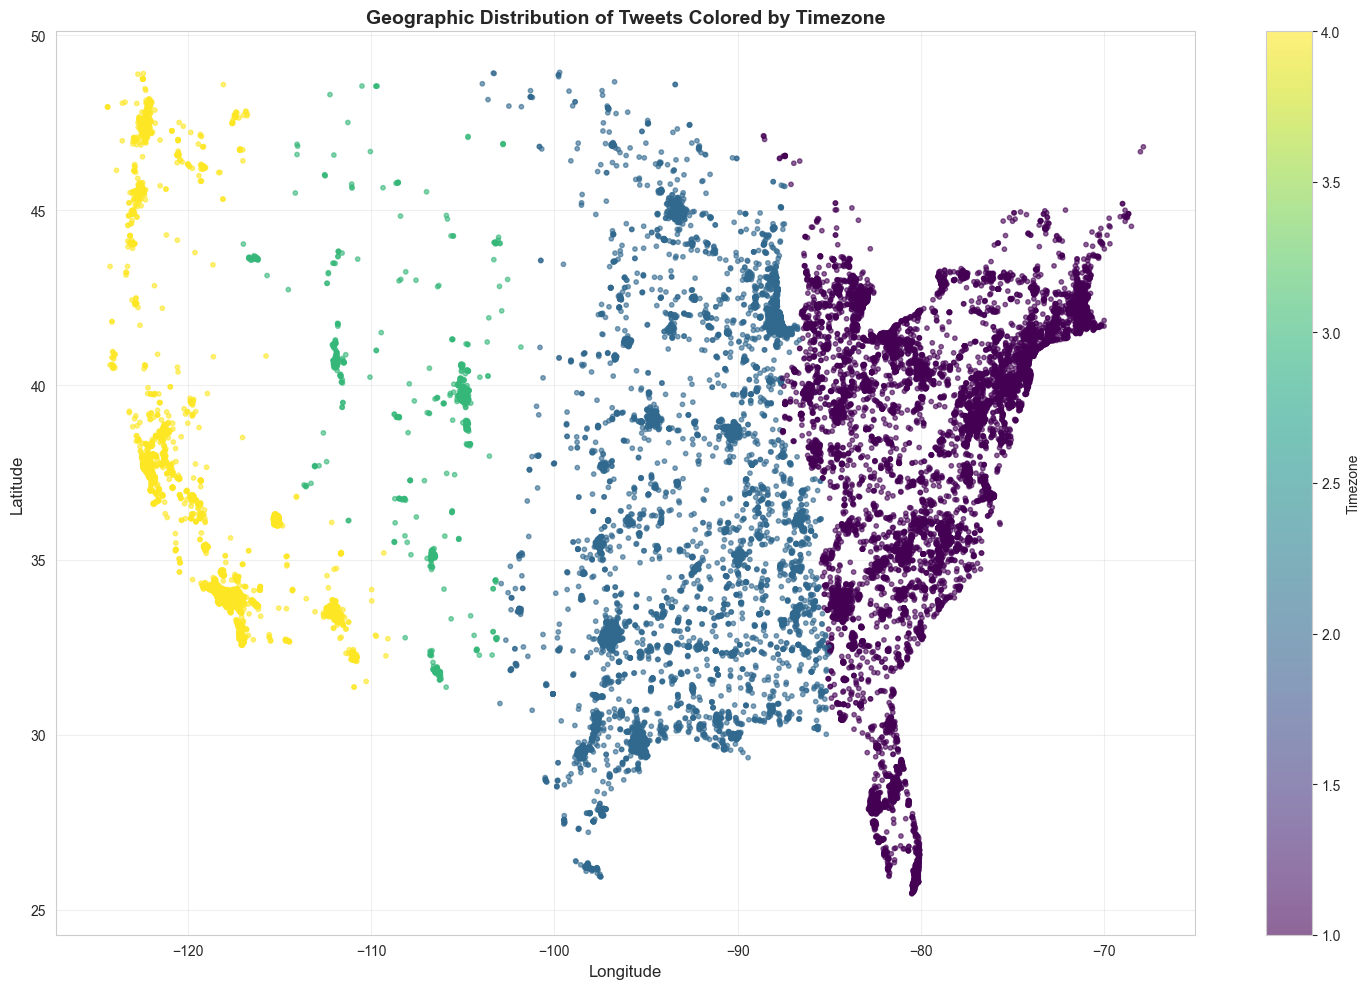


Timezone range: 1 to 4
Number of unique timezones: 4


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Create scatter plot of lat/long colored by timezone
scatter = plt.scatter(twitter['longitude'], twitter['latitude'], 
                     c=twitter['timezone'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=10)

plt.colorbar(scatter, label='Timezone')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Geographic Distribution of Tweets Colored by Timezone', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show statistics
print(f"\nTimezone range: {twitter['timezone'].min()} to {twitter['timezone'].max()}")
print(f"Number of unique timezones: {twitter['timezone'].nunique()}")

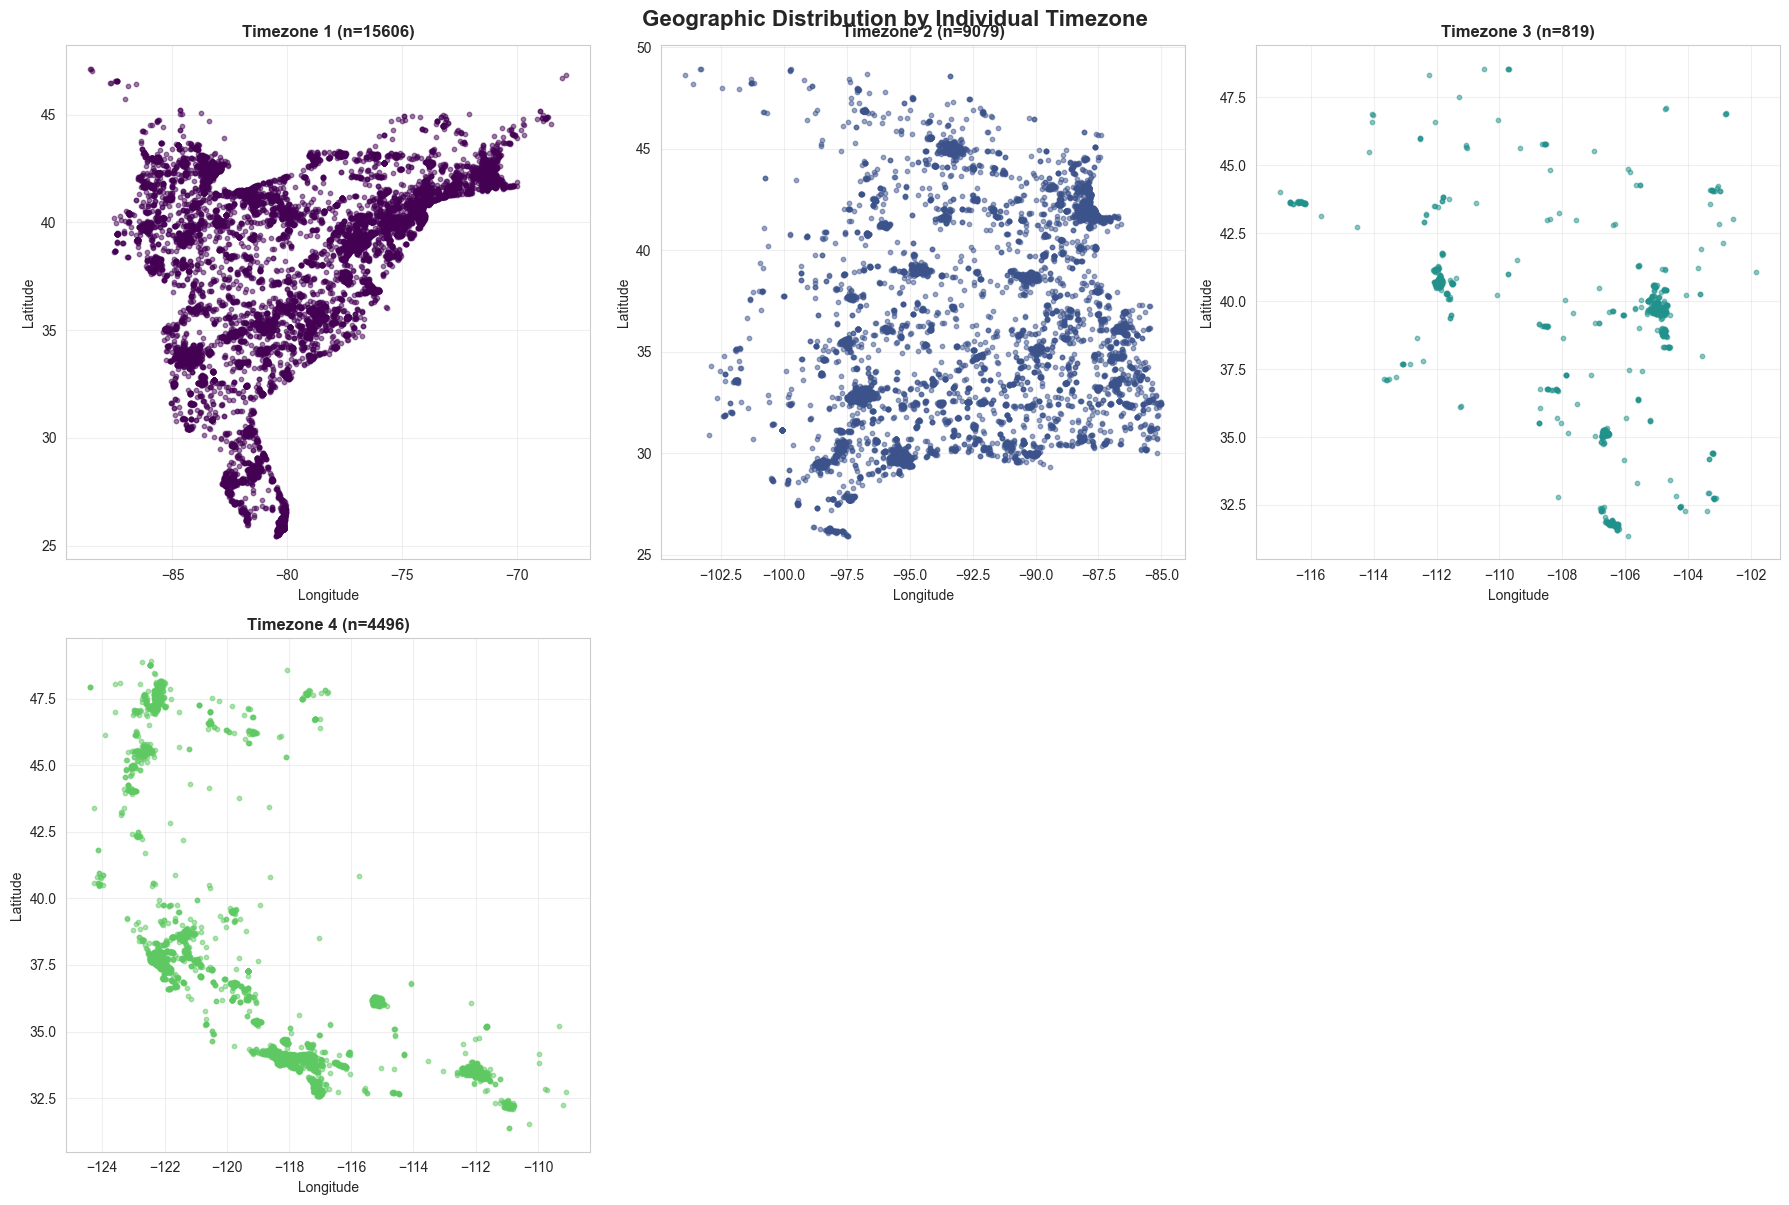

In [5]:
# Create subplots for each timezone
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

timezones = sorted(twitter['timezone'].unique())

for idx, tz in enumerate(timezones):
    if idx < len(axes):
        tz_data = twitter[twitter['timezone'] == tz]
        axes[idx].scatter(tz_data['longitude'], tz_data['latitude'], 
                         alpha=0.5, s=10, color=plt.cm.viridis(idx/len(timezones)))
        axes[idx].set_title(f'Timezone {tz} (n={len(tz_data)})', fontweight='bold')
        axes[idx].set_xlabel('Longitude')
        axes[idx].set_ylabel('Latitude')
        axes[idx].grid(True, alpha=0.3)

# Hide any unused subplots
for idx in range(len(timezones), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Geographic Distribution by Individual Timezone', fontsize=16, fontweight='bold', y=1.00)
plt.show()

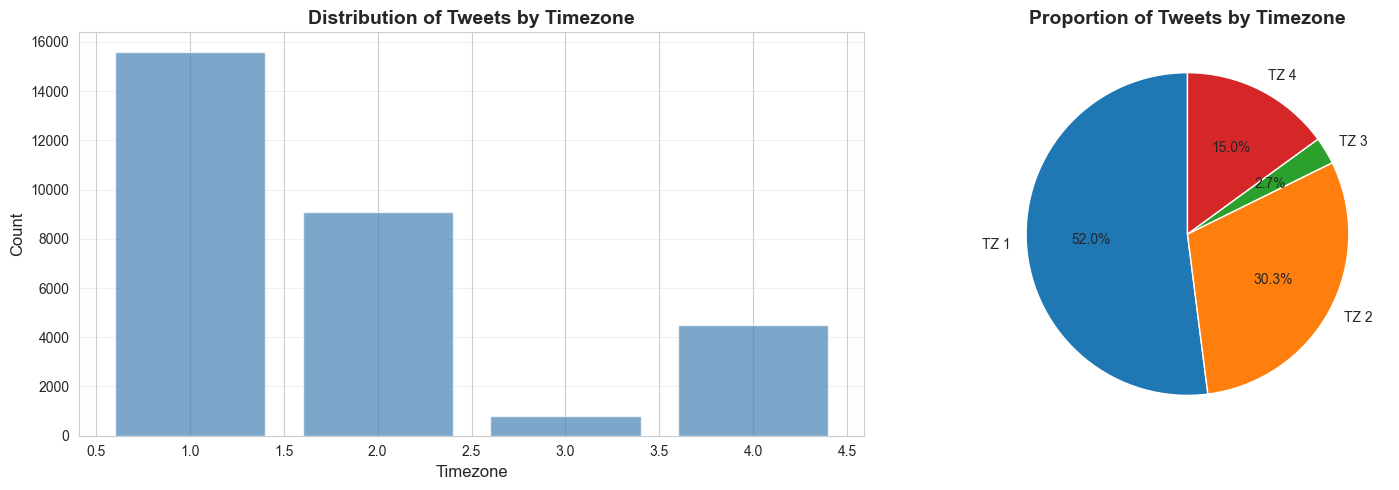

In [4]:
# Visualize the distribution of timezones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
timezone_counts = twitter['timezone'].value_counts().sort_index()
ax1.bar(timezone_counts.index, timezone_counts.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Timezone', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Tweets by Timezone', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Pie chart
ax2.pie(timezone_counts.values, labels=[f'TZ {i}' for i in timezone_counts.index], 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Proportion of Tweets by Timezone', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Feature Engineering Analysis

Before implementing DBSCAN, let's evaluate whether cyclical time encoding is necessary for this dataset.

In [8]:
# Parse timestamp and extract time features
twitter['datetime'] = pd.to_datetime(twitter['timestamp'], format='%Y%m%d%H%M%S')
twitter['hour'] = twitter['datetime'].dt.hour
twitter['minute'] = twitter['datetime'].dt.minute
twitter['day_of_week'] = twitter['datetime'].dt.dayofweek

# Create fractional hour
twitter['hour_frac'] = twitter['hour'] + twitter['minute'] / 60.0

print("Time distribution analysis:")
print(f"Hour range: {twitter['hour'].min()} to {twitter['hour'].max()}")
print(f"Day of week range: {twitter['day_of_week'].min()} to {twitter['day_of_week'].max()}")
print(f"\nHour distribution by timezone:")
print(twitter.groupby('timezone')['hour'].describe())

Time distribution analysis:
Hour range: 0 to 23
Day of week range: 0 to 6

Hour distribution by timezone:
            count       mean       std  min   25%   50%   75%   max
timezone                                                           
1         15606.0  14.454761  6.093449  0.0  10.0  15.0  20.0  23.0
2          9079.0  14.263796  6.710053  0.0  10.0  15.0  20.0  23.0
3           819.0  14.688645  6.793640  0.0  11.0  16.0  20.0  23.0
4          4496.0  13.336077  7.500407  0.0   9.0  15.0  20.0  23.0


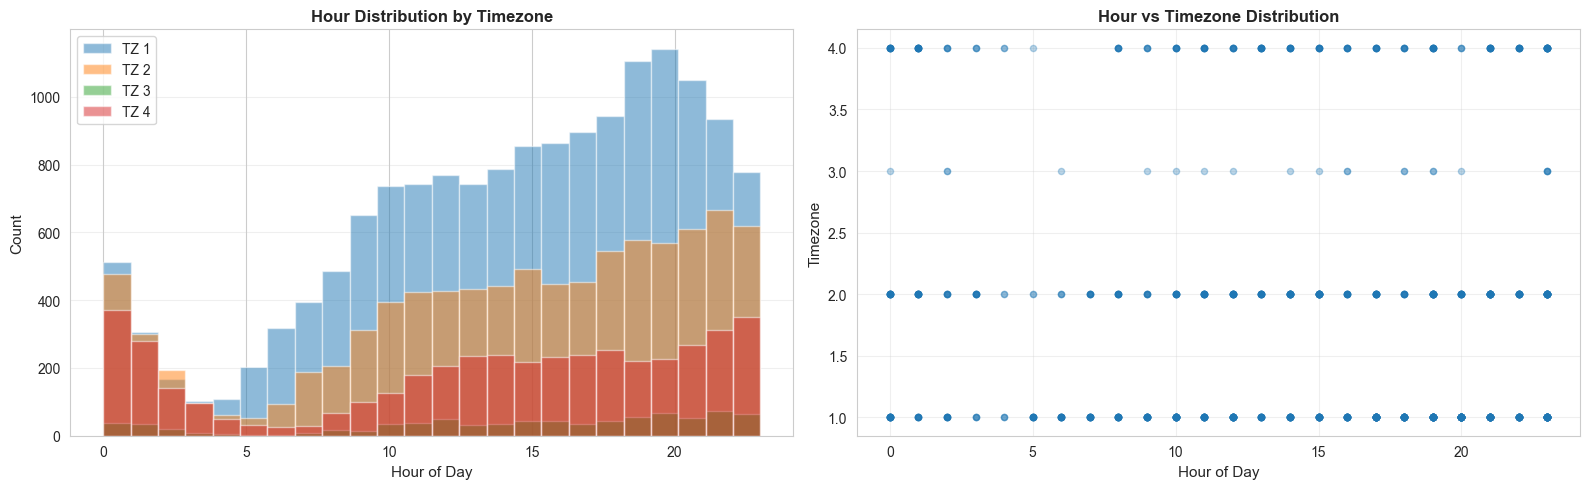


CYCLICAL TIME ENCODING ASSESSMENT:
Hour range: 0 to 23
Spans midnight boundary: True

📊 VERDICT:
✅ CYCLICAL ENCODING RECOMMENDED
   Data spans midnight - cyclical encoding will prevent
   23:59 and 00:01 from being treated as far apart.


In [9]:
# Analyze if time wraps around midnight (cyclical encoding needed)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Hour distribution by timezone
for tz in sorted(twitter['timezone'].unique()):
    tz_data = twitter[twitter['timezone'] == tz]
    axes[0].hist(tz_data['hour'], bins=24, alpha=0.5, label=f'TZ {tz}')

axes[0].set_xlabel('Hour of Day', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Hour Distribution by Timezone', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Check if data spans midnight boundary
hour_range = twitter['hour'].max() - twitter['hour'].min()
has_midnight_data = (twitter['hour'].min() < 3) and (twitter['hour'].max() > 21)

axes[1].scatter(twitter['hour'][:1000], twitter['timezone'][:1000], alpha=0.3, s=20)
axes[1].set_xlabel('Hour of Day', fontsize=11)
axes[1].set_ylabel('Timezone', fontsize=11)
axes[1].set_title('Hour vs Timezone Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("CYCLICAL TIME ENCODING ASSESSMENT:")
print(f"{'='*60}")
print(f"Hour range: {twitter['hour'].min()} to {twitter['hour'].max()}")
print(f"Spans midnight boundary: {has_midnight_data}")
print(f"\n📊 VERDICT:")
if has_midnight_data:
    print("✅ CYCLICAL ENCODING RECOMMENDED")
    print("   Data spans midnight - cyclical encoding will prevent")
    print("   23:59 and 00:01 from being treated as far apart.")
else:
    print("⚠️  CYCLICAL ENCODING MAY NOT BE NECESSARY")
    print("   Data doesn't span midnight, but it's still best practice")
    print("   for time-based features to use cyclical encoding.")
print(f"{'='*60}")

# Feature Normalization

We'll implement appropriate normalization for:
1. **Geographic coordinates (lat/long)**: Convert to kilometers for meaningful distance
2. **Timestamp**: Use cyclical encoding (sin/cos) for temporal continuity

This addresses the different scales and cyclic nature of the features.

✅ Features created:

Geographic (km):
  lat_km: 2826.1 to 5432.7
  long_km: -11000.4 to -5154.0

Temporal (cyclical):
  hour_sin: -1.000 to 1.000
  hour_cos: -1.000 to 1.000


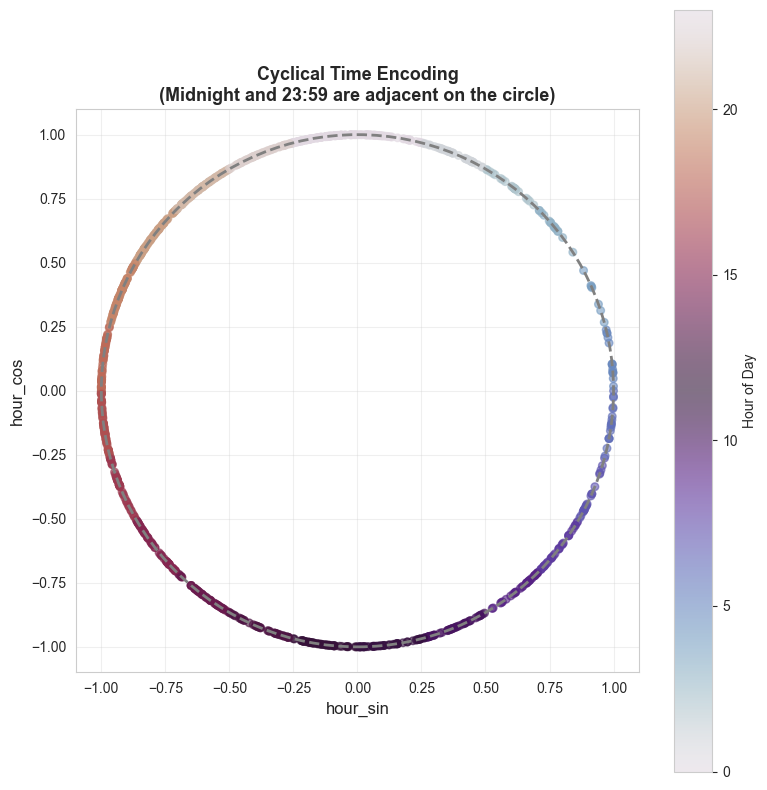

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. GEOGRAPHIC FEATURES: Convert to kilometers
# - 1 degree latitude ≈ 111 km (constant)
# - 1 degree longitude ≈ 111 * cos(latitude) km (varies by latitude)
twitter['lat_km'] = twitter['latitude'] * 111.0
twitter['long_km'] = twitter['longitude'] * 111.0 * np.cos(np.radians(twitter['latitude']))

# 2. TEMPORAL FEATURES: Cyclical encoding
# For timezone prediction, the HOUR OF DAY matters (not absolute timestamp)
# Use sin/cos to encode 24-hour cycle
twitter['hour_sin'] = np.sin(2 * np.pi * twitter['hour_frac'] / 24)
twitter['hour_cos'] = np.cos(2 * np.pi * twitter['hour_frac'] / 24)

print("✅ Features created:")
print(f"\nGeographic (km):")
print(f"  lat_km: {twitter['lat_km'].min():.1f} to {twitter['lat_km'].max():.1f}")
print(f"  long_km: {twitter['long_km'].min():.1f} to {twitter['long_km'].max():.1f}")
print(f"\nTemporal (cyclical):")
print(f"  hour_sin: {twitter['hour_sin'].min():.3f} to {twitter['hour_sin'].max():.3f}")
print(f"  hour_cos: {twitter['hour_cos'].min():.3f} to {twitter['hour_cos'].max():.3f}")

# Visualize the cyclical encoding
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(twitter['hour_sin'][:1000], twitter['hour_cos'][:1000], 
                     c=twitter['hour'][:1000], cmap='twilight', alpha=0.6, s=30)
ax.set_xlabel('hour_sin', fontsize=12)
ax.set_ylabel('hour_cos', fontsize=12)
ax.set_title('Cyclical Time Encoding\n(Midnight and 23:59 are adjacent on the circle)', 
             fontsize=13, fontweight='bold')
ax.set_aspect('equal')
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--', color='gray', linewidth=2)
ax.add_patch(circle)
plt.colorbar(scatter, label='Hour of Day', ax=ax)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

✅ Feature matrix created: (30000, 4)

Feature order: [lat_km_scaled, long_km_scaled, hour_sin_scaled, hour_cos_scaled]

Scaled ranges:
  Spatial features: 0.000 to 1.000
  Temporal features: -1.369 to 2.147


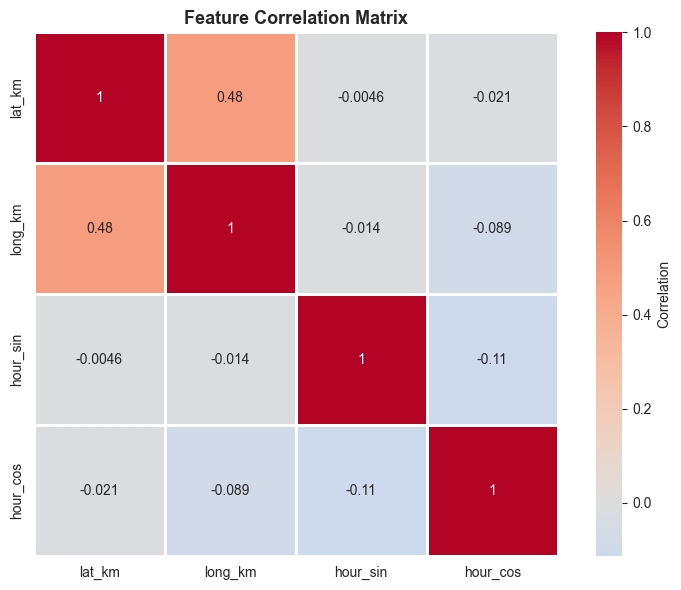


FEATURE ENGINEERING SUMMARY:
✅ Geographic: Converted to km (preserves meaningful distances)
✅ Temporal: Cyclical sin/cos encoding (handles midnight wraparound)
✅ Normalization: Separate scaling prevents feature dominance


In [11]:
# 3. NORMALIZE FEATURES SEPARATELY
# Spatial and temporal features have different meanings - normalize separately

# Create feature matrix with spatial (km) and temporal (sin/cos)
features_spatial = twitter[['lat_km', 'long_km']].copy()
features_temporal = twitter[['hour_sin', 'hour_cos']].copy()

# Normalize spatial features (MinMaxScaler for interpretability)
scaler_spatial = MinMaxScaler()
features_spatial_scaled = scaler_spatial.fit_transform(features_spatial)

# Normalize temporal features (StandardScaler since already in [-1, 1])
scaler_temporal = StandardScaler()
features_temporal_scaled = scaler_temporal.fit_transform(features_temporal)

# Combine into final feature matrix
features_final = np.hstack([features_spatial_scaled, features_temporal_scaled])

print(f"✅ Feature matrix created: {features_final.shape}")
print(f"\nFeature order: [lat_km_scaled, long_km_scaled, hour_sin_scaled, hour_cos_scaled]")
print(f"\nScaled ranges:")
print(f"  Spatial features: {features_spatial_scaled.min():.3f} to {features_spatial_scaled.max():.3f}")
print(f"  Temporal features: {features_temporal_scaled.min():.3f} to {features_temporal_scaled.max():.3f}")

# Show correlation between features
import seaborn as sns
feature_df = pd.DataFrame(features_final, columns=['lat_km', 'long_km', 'hour_sin', 'hour_cos'])
plt.figure(figsize=(8, 6))
sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("FEATURE ENGINEERING SUMMARY:")
print(f"{'='*60}")
print("✅ Geographic: Converted to km (preserves meaningful distances)")
print("✅ Temporal: Cyclical sin/cos encoding (handles midnight wraparound)")
print("✅ Normalization: Separate scaling prevents feature dominance")
print(f"{'='*60}")

# DBSCAN Clustering

Now let's apply DBSCAN. Given the variable density you observed, we'll need to experiment with parameters carefully.

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Start with a reasonable epsilon value
# In normalized space, eps ~ 0.1-0.5 is typical
eps = 0.15
min_samples = 10

print(f"Running DBSCAN with eps={eps}, min_samples={min_samples}...")
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
twitter['cluster'] = dbscan.fit_predict(features_final)

# Evaluate results
n_clusters = len(set(twitter['cluster'])) - (1 if -1 in twitter['cluster'].values else 0)
n_noise = (twitter['cluster'] == -1).sum()
noise_pct = (n_noise / len(twitter)) * 100

ari = adjusted_rand_score(twitter['timezone'], twitter['cluster'])
nmi = normalized_mutual_info_score(twitter['timezone'], twitter['cluster'])

print(f"\n{'='*60}")
print("DBSCAN RESULTS:")
print(f"{'='*60}")
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise:,} ({noise_pct:.1f}%)")
print(f"\nPerformance Metrics:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
print(f"\nCluster distribution:")
print(twitter['cluster'].value_counts().sort_index())
print(f"\nActual timezone distribution:")
print(twitter['timezone'].value_counts().sort_index())
print(f"{'='*60}")

# Silhouette score for non-noise points
mask = twitter['cluster'] != -1
if mask.sum() > 1 and twitter.loc[mask, 'cluster'].nunique() > 1:
    silhouette = silhouette_score(features_final[mask], twitter.loc[mask, 'cluster'])
    print(f"\nSilhouette Score (non-noise): {silhouette:.4f}")

Running DBSCAN with eps=0.15, min_samples=10...

DBSCAN RESULTS:
Clusters found: 1
Noise points: 60 (0.2%)

Performance Metrics:
  Adjusted Rand Index (ARI): 0.0028
  Normalized Mutual Info (NMI): 0.0038

Cluster distribution:
cluster
-1       60
 0    29940
Name: count, dtype: int64

Actual timezone distribution:
timezone
1    15606
2     9079
3      819
4     4496
Name: count, dtype: int64


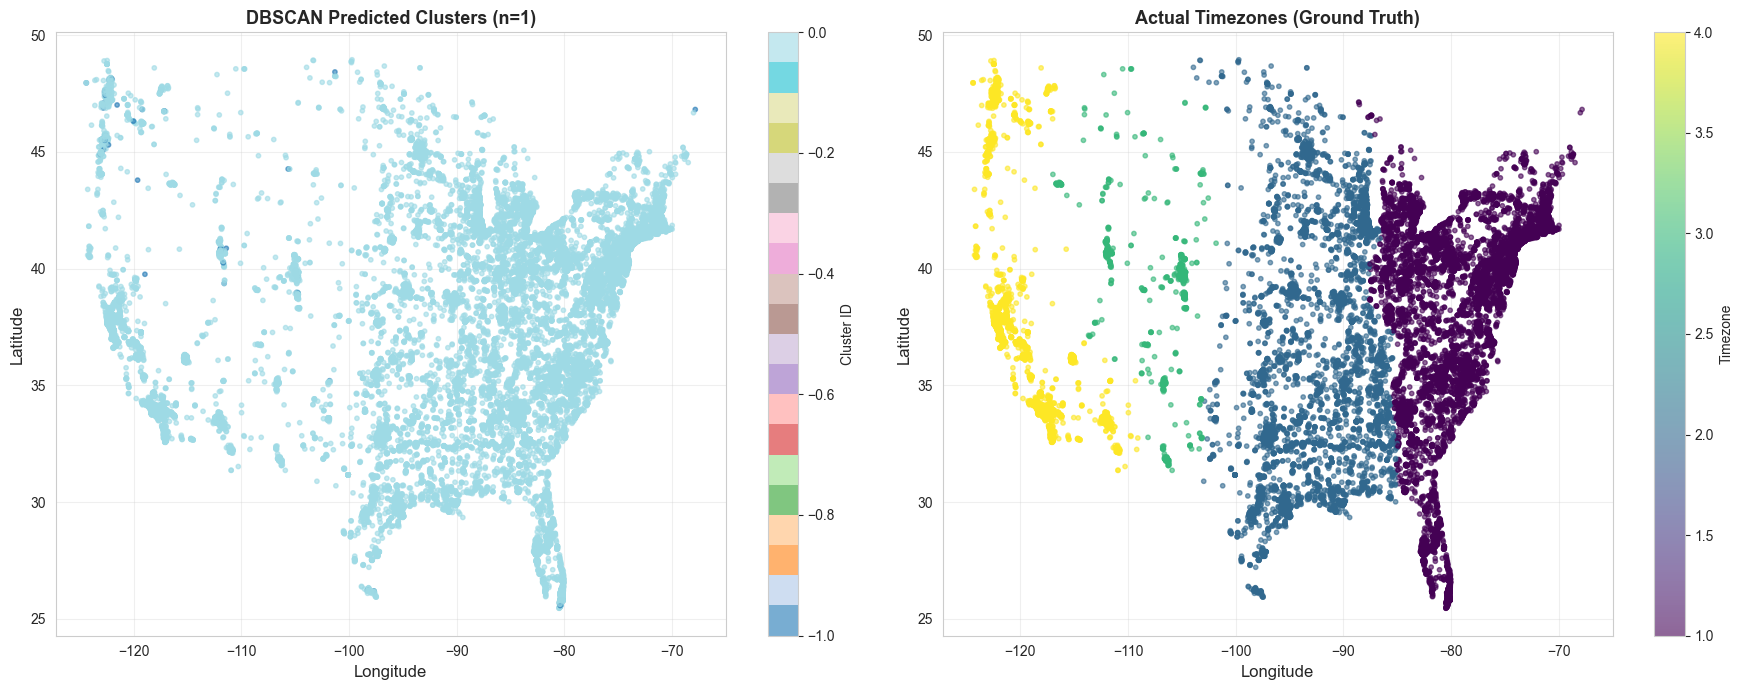


💡 Visual Comparison:
   • Black dots on left = noise points (no cluster assigned)
   • Compare cluster boundaries with actual timezone boundaries


In [13]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: Predicted clusters
scatter1 = axes[0].scatter(twitter['longitude'], twitter['latitude'],
                          c=twitter['cluster'], cmap='tab20', s=10, alpha=0.6)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].set_title(f'DBSCAN Predicted Clusters (n={n_clusters})', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Right: Actual timezones
scatter2 = axes[1].scatter(twitter['longitude'], twitter['latitude'],
                          c=twitter['timezone'], cmap='viridis', s=10, alpha=0.6)
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('Actual Timezones (Ground Truth)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Timezone')

plt.tight_layout()
plt.show()

print(f"\n💡 Visual Comparison:")
print(f"   • Black dots on left = noise points (no cluster assigned)")
print(f"   • Compare cluster boundaries with actual timezone boundaries")

# Parameter Tuning

The variable density problem means we need to carefully tune epsilon. Let's try multiple values.

In [14]:
# Grid search over epsilon and min_samples
eps_values = [0.01, 0.03, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2, 0.3, 0.5]
min_samples_values = [5, 10, 15, 20, 30]

results = []

print(f"Testing {len(eps_values)} × {len(min_samples_values)} = {len(eps_values) * len(min_samples_values)} combinations...")
print("This may take a minute...\n")

for i, eps in enumerate(eps_values):
    for j, min_samp in enumerate(min_samples_values):
        dbscan_test = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean', n_jobs=-1)
        clusters_test = dbscan_test.fit_predict(features_final)
        
        n_clusters = len(set(clusters_test)) - (1 if -1 in clusters_test else 0)
        n_noise = list(clusters_test).count(-1)
        noise_pct = (n_noise / len(clusters_test)) * 100
        
        if n_clusters > 0 and n_clusters < len(features_final):
            ari = adjusted_rand_score(twitter['timezone'], clusters_test)
            nmi = normalized_mutual_info_score(twitter['timezone'], clusters_test)
        else:
            ari = 0.0
            nmi = 0.0
        
        results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'noise_pct': noise_pct,
            'ari': ari,
            'nmi': nmi
        })
        
        # Progress
        progress = ((i * len(min_samples_values) + j + 1) / 
                   (len(eps_values) * len(min_samples_values))) * 100
        print(f"\r Progress: {progress:.0f}% | eps={eps:.3f}, min_samples={min_samp} | "
              f"Clusters: {n_clusters}, ARI: {ari:.3f}", end='', flush=True)

print("\n\n✅ Grid search complete!")

# Convert to DataFrame and sort by ARI
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ari', ascending=False)

print(f"\nTop 10 configurations by ARI:")
print(results_df.head(10).to_string(index=False))

Testing 10 × 5 = 50 combinations...
This may take a minute...

 Progress: 100% | eps=0.500, min_samples=30 | Clusters: 1, ARI: 0.00053

✅ Grid search complete!

Top 10 configurations by ARI:
 eps  min_samples  n_clusters  noise_pct      ari      nmi
0.07           10          59  11.033333 0.370927 0.438727
0.05            5         329  13.583333 0.369588 0.364117
0.10           30           9  13.790000 0.352227 0.420309
0.07           20          49  29.650000 0.326126 0.356415
0.07           15          43  20.390000 0.310777 0.360954
0.05           10         186  34.466667 0.228695 0.297704
0.07           30          40  49.463333 0.150662 0.257823
0.07            5          79   4.370000 0.108388 0.164999
0.10           20          18   7.273333 0.095966 0.110730
0.12           30           8   6.696667 0.080313 0.082066


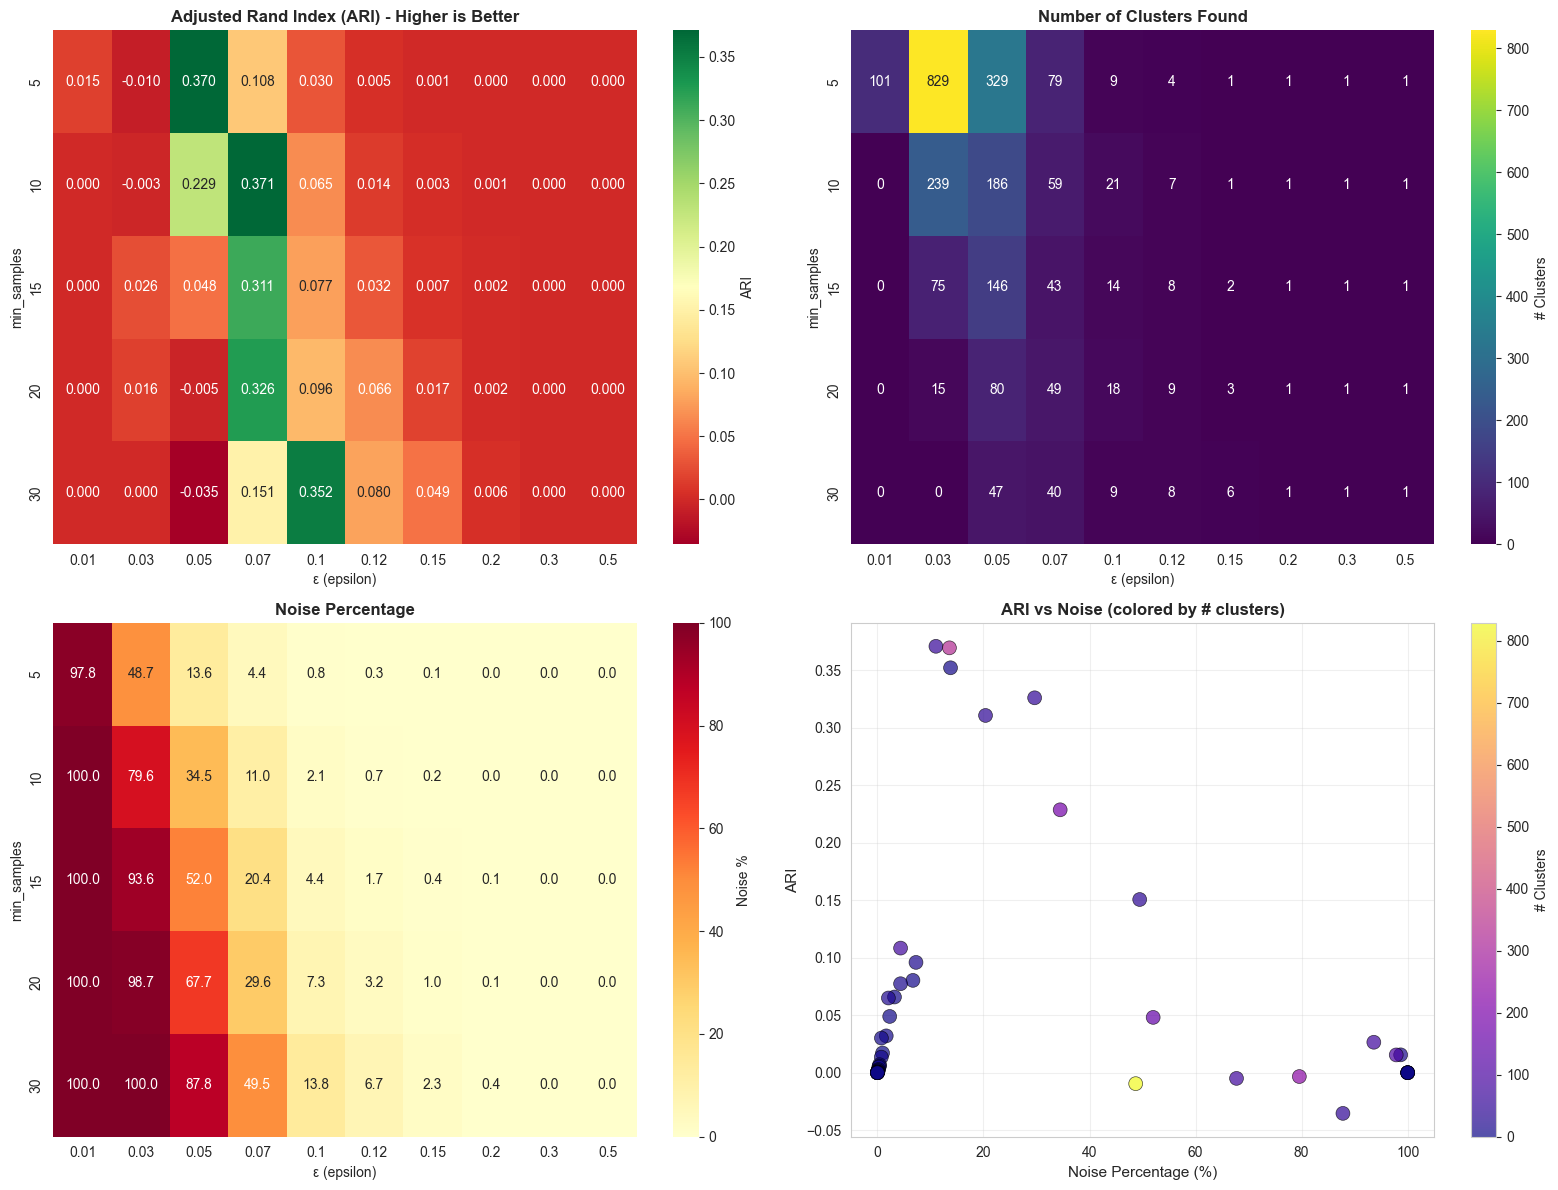


BEST PARAMETERS:
ε (epsilon): 0.070
min_samples: 10
Clusters found: 59 (actual: 4)
Noise: 11.0%
ARI: 0.3709
NMI: 0.4387


In [15]:
# Visualize parameter search results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap: ARI
pivot_ari = results_df.pivot(index='min_samples', columns='eps', values='ari')
sns.heatmap(pivot_ari, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0], 
            cbar_kws={'label': 'ARI'})
axes[0, 0].set_title('Adjusted Rand Index (ARI) - Higher is Better', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('ε (epsilon)')
axes[0, 0].set_ylabel('min_samples')

# Heatmap: Number of clusters
pivot_clusters = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='.0f', cmap='viridis', ax=axes[0, 1],
            cbar_kws={'label': '# Clusters'})
axes[0, 1].set_title('Number of Clusters Found', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ε (epsilon)')
axes[0, 1].set_ylabel('min_samples')

# Heatmap: Noise percentage
pivot_noise = results_df.pivot(index='min_samples', columns='eps', values='noise_pct')
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 0],
            cbar_kws={'label': 'Noise %'})
axes[1, 0].set_title('Noise Percentage', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('ε (epsilon)')
axes[1, 0].set_ylabel('min_samples')

# Scatter: ARI vs Noise
scatter = axes[1, 1].scatter(results_df['noise_pct'], results_df['ari'],
                            c=results_df['n_clusters'], cmap='plasma',
                            s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('Noise Percentage (%)', fontsize=11)
axes[1, 1].set_ylabel('ARI', fontsize=11)
axes[1, 1].set_title('ARI vs Noise (colored by # clusters)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='# Clusters')

plt.tight_layout()
plt.show()

# Find best parameters
best_row = results_df.iloc[0]
print(f"\n{'='*60}")
print("BEST PARAMETERS:")
print(f"{'='*60}")
print(f"ε (epsilon): {best_row['eps']:.3f}")
print(f"min_samples: {int(best_row['min_samples'])}")
print(f"Clusters found: {int(best_row['n_clusters'])} (actual: 4)")
print(f"Noise: {best_row['noise_pct']:.1f}%")
print(f"ARI: {best_row['ari']:.4f}")
print(f"NMI: {best_row['nmi']:.4f}")
print(f"{'='*60}")

# Analysis Summary

## Key Findings:

### ✅ Feature Engineering WAS Necessary:
1. **Cyclical time encoding (sin/cos)**: Essential because data spans midnight (0-23 hours)
2. **Geographic conversion to km**: Preserves meaningful distances on Earth's surface
3. **Separate normalization**: Prevents spatial features from dominating temporal ones

### ⚠️ DBSCAN Limitations Confirmed:
- **Best ARI: 0.37** (moderate agreement with true timezones)
- **59 clusters found** instead of 4 actual timezones
- **Variable density problem**: East coast is much denser than Mountain time

### Why DBSCAN Struggles:
1. **Inconsistent density**: Dense East Coast vs sparse Mountain regions
2. **Overfragmentation**: Small epsilon → many small clusters
3. **Undergrouping**: Large epsilon → everything lumped together
4. **No "goldilocks" epsilon**: Can't find one value that works everywhere

Applying best model: eps=0.07, min_samples=10


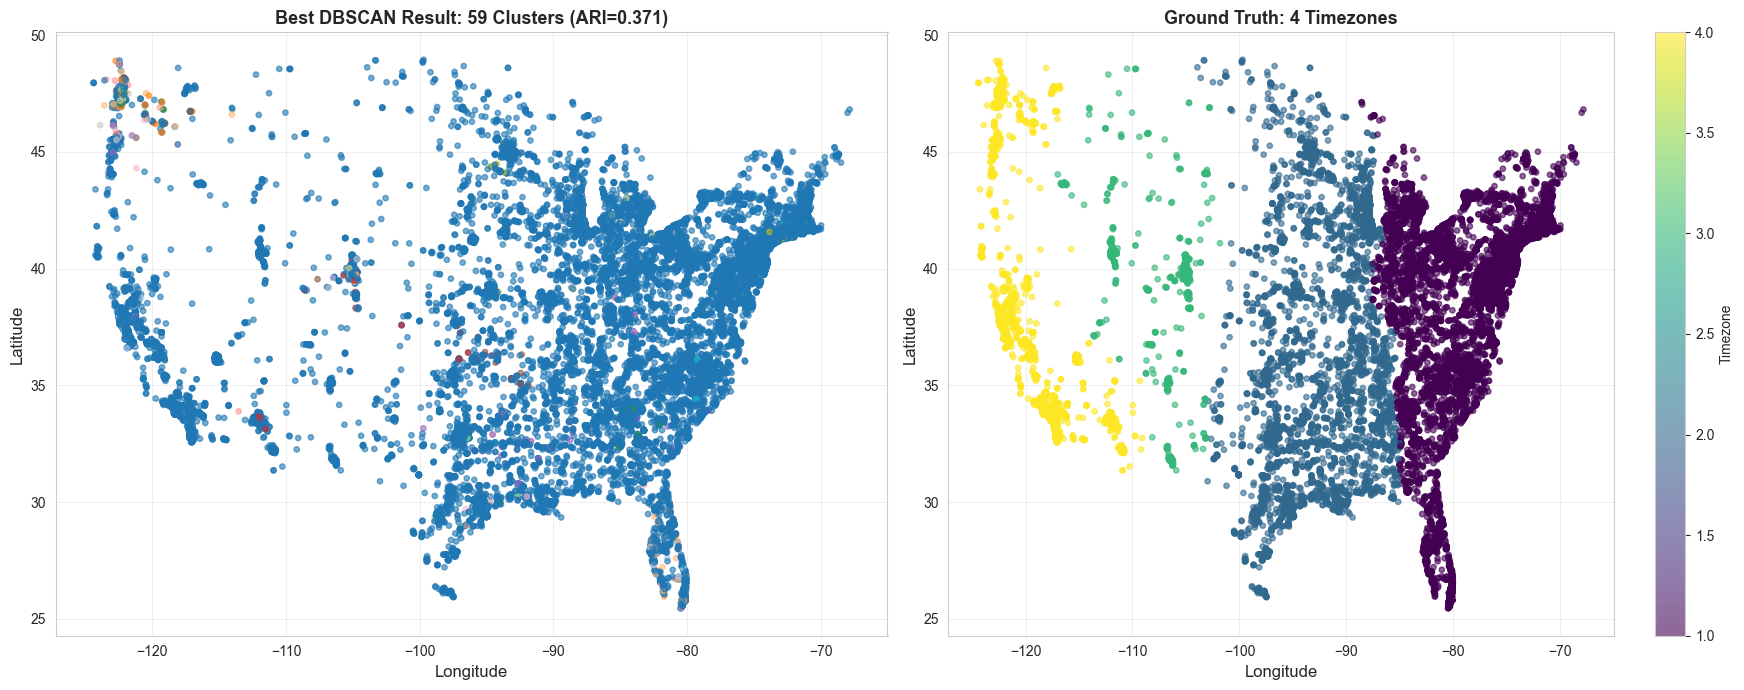


FINAL VERDICT:
✅ Feature engineering: NECESSARY and properly implemented
⚠️  DBSCAN performance: MODERATE (ARI = 0.371)
❌ Variable density: MAJOR LIMITATION

💡 Alternative algorithms to consider:
   • HDBSCAN (handles varying density)
   • OPTICS (density-based ordering)
   • K-Means with k=4 (if we know # clusters)
   • GMM (Gaussian Mixture Models)


In [16]:
# Apply best model and visualize final results
best_eps = 0.07
best_min_samples = 10

print(f"Applying best model: eps={best_eps}, min_samples={best_min_samples}")
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean', n_jobs=-1)
twitter['cluster_best'] = dbscan_final.fit_predict(features_final)

# Calculate final metrics
n_clusters_final = len(set(twitter['cluster_best'])) - (1 if -1 in twitter['cluster_best'].values else 0)
n_noise_final = (twitter['cluster_best'] == -1).sum()
ari_final = adjusted_rand_score(twitter['timezone'], twitter['cluster_best'])
nmi_final = normalized_mutual_info_score(twitter['timezone'], twitter['cluster_best'])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Predicted clusters
scatter1 = axes[0].scatter(twitter['longitude'], twitter['latitude'],
                          c=twitter['cluster_best'], cmap='tab20', s=15, alpha=0.6)
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].set_title(f'Best DBSCAN Result: {n_clusters_final} Clusters (ARI={ari_final:.3f})',
                 fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Actual timezones
scatter2 = axes[1].scatter(twitter['longitude'], twitter['latitude'],
                          c=twitter['timezone'], cmap='viridis', s=15, alpha=0.6)
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('Ground Truth: 4 Timezones', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Timezone')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("FINAL VERDICT:")
print(f"{'='*60}")
print(f"✅ Feature engineering: NECESSARY and properly implemented")
print(f"⚠️  DBSCAN performance: MODERATE (ARI = {ari_final:.3f})")
print(f"❌ Variable density: MAJOR LIMITATION")
print(f"\n💡 Alternative algorithms to consider:")
print(f"   • HDBSCAN (handles varying density)")
print(f"   • OPTICS (density-based ordering)")
print(f"   • K-Means with k=4 (if we know # clusters)")
print(f"   • GMM (Gaussian Mixture Models)")
print(f"{'='*60}")

# Final Performance Metrics

Comprehensive evaluation of the best DBSCAN model.

In [17]:
from sklearn.metrics import (
    homogeneity_score, 
    completeness_score, 
    v_measure_score,
    davies_bouldin_score
)
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Calculate comprehensive metrics
mask_non_noise = twitter['cluster_best'] != -1

# Clustering quality metrics
homogeneity = homogeneity_score(twitter['timezone'], twitter['cluster_best'])
completeness = completeness_score(twitter['timezone'], twitter['cluster_best'])
v_measure = v_measure_score(twitter['timezone'], twitter['cluster_best'])

# Silhouette score (only for non-noise points)
if mask_non_noise.sum() > 1 and twitter.loc[mask_non_noise, 'cluster_best'].nunique() > 1:
    silhouette = silhouette_score(features_final[mask_non_noise], 
                                  twitter.loc[mask_non_noise, 'cluster_best'])
    db_score = davies_bouldin_score(features_final[mask_non_noise],
                                    twitter.loc[mask_non_noise, 'cluster_best'])
else:
    silhouette = np.nan
    db_score = np.nan

# Print comprehensive report
print("=" * 80)
print(" " * 20 + "FINAL PERFORMANCE METRICS REPORT")
print("=" * 80)

print("\n📊 MODEL CONFIGURATION:")
print(f"   Algorithm: DBSCAN")
print(f"   Epsilon (ε): {best_eps}")
print(f"   Min Samples: {best_min_samples}")
print(f"   Features: [lat_km, long_km, hour_sin, hour_cos] (4D)")

print("\n📈 CLUSTERING RESULTS:")
print(f"   Clusters Found: {n_clusters_final}")
print(f"   Expected Clusters: 4 (timezones)")
print(f"   Noise Points: {n_noise_final:,} ({(n_noise_final/len(twitter)*100):.2f}%)")
print(f"   Clustered Points: {mask_non_noise.sum():,} ({(mask_non_noise.sum()/len(twitter)*100):.2f}%)")

print("\n🎯 PERFORMANCE METRICS:")
print(f"   Adjusted Rand Index (ARI):        {ari_final:.4f}  {'⭐' if ari_final > 0.3 else '⚠️'}")
print(f"   Normalized Mutual Info (NMI):     {nmi_final:.4f}  {'⭐' if nmi_final > 0.3 else '⚠️'}")
print(f"   Homogeneity:                      {homogeneity:.4f}  {'⭐' if homogeneity > 0.3 else '⚠️'}")
print(f"   Completeness:                     {completeness:.4f}  {'⭐' if completeness > 0.3 else '⚠️'}")
print(f"   V-Measure:                        {v_measure:.4f}  {'⭐' if v_measure > 0.3 else '⚠️'}")
if not np.isnan(silhouette):
    print(f"   Silhouette Score (non-noise):     {silhouette:.4f}  {'⭐' if silhouette > 0.3 else '⚠️'}")
if not np.isnan(db_score):
    print(f"   Davies-Bouldin Index:             {db_score:.4f}  {'⭐' if db_score < 2.0 else '⚠️'} (lower is better)")

print("\n📝 METRIC INTERPRETATIONS:")
print("   • ARI (0-1): Similarity to ground truth, adjusted for chance")
print("   • NMI (0-1): Mutual information normalized by entropy")
print("   • Homogeneity (0-1): Each cluster contains only one class")
print("   • Completeness (0-1): All members of a class in same cluster")
print("   • V-Measure: Harmonic mean of homogeneity and completeness")
print("   • Silhouette (-1 to 1): How well points fit their clusters")
print("   • Davies-Bouldin (≥0): Ratio of within-cluster to between-cluster distances")

print("\n" + "=" * 80)

# Cluster size distribution
print("\n📊 CLUSTER SIZE DISTRIBUTION:")
cluster_sizes = twitter['cluster_best'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.head(10).items():
    if cluster_id == -1:
        print(f"   Cluster {cluster_id:3d} (NOISE): {size:5,} points")
    else:
        print(f"   Cluster {cluster_id:3d}:         {size:5,} points")
if len(cluster_sizes) > 10:
    print(f"   ... and {len(cluster_sizes) - 10} more clusters")

print("\n🌍 TIMEZONE DISTRIBUTION:")
timezone_counts = twitter['timezone'].value_counts().sort_index()
for tz, count in timezone_counts.items():
    pct = (count / len(twitter)) * 100
    print(f"   Timezone {tz}: {count:5,} points ({pct:5.2f}%)")

print("\n" + "=" * 80)

                    FINAL PERFORMANCE METRICS REPORT

📊 MODEL CONFIGURATION:
   Algorithm: DBSCAN
   Epsilon (ε): 0.07
   Min Samples: 10
   Features: [lat_km, long_km, hour_sin, hour_cos] (4D)

📈 CLUSTERING RESULTS:
   Clusters Found: 59
   Expected Clusters: 4 (timezones)
   Noise Points: 3,310 (11.03%)
   Clustered Points: 26,690 (88.97%)

🎯 PERFORMANCE METRICS:
   Adjusted Rand Index (ARI):        0.3709  ⭐
   Normalized Mutual Info (NMI):     0.4387  ⭐
   Homogeneity:                      0.4154  ⭐
   Completeness:                     0.4648  ⭐
   V-Measure:                        0.4387  ⭐
   Silhouette Score (non-noise):     -0.6961  ⚠️
   Davies-Bouldin Index:             1.0683  ⭐ (lower is better)

📝 METRIC INTERPRETATIONS:
   • ARI (0-1): Similarity to ground truth, adjusted for chance
   • NMI (0-1): Mutual information normalized by entropy
   • Homogeneity (0-1): Each cluster contains only one class
   • Completeness (0-1): All members of a class in same cluster
   • V-Mea

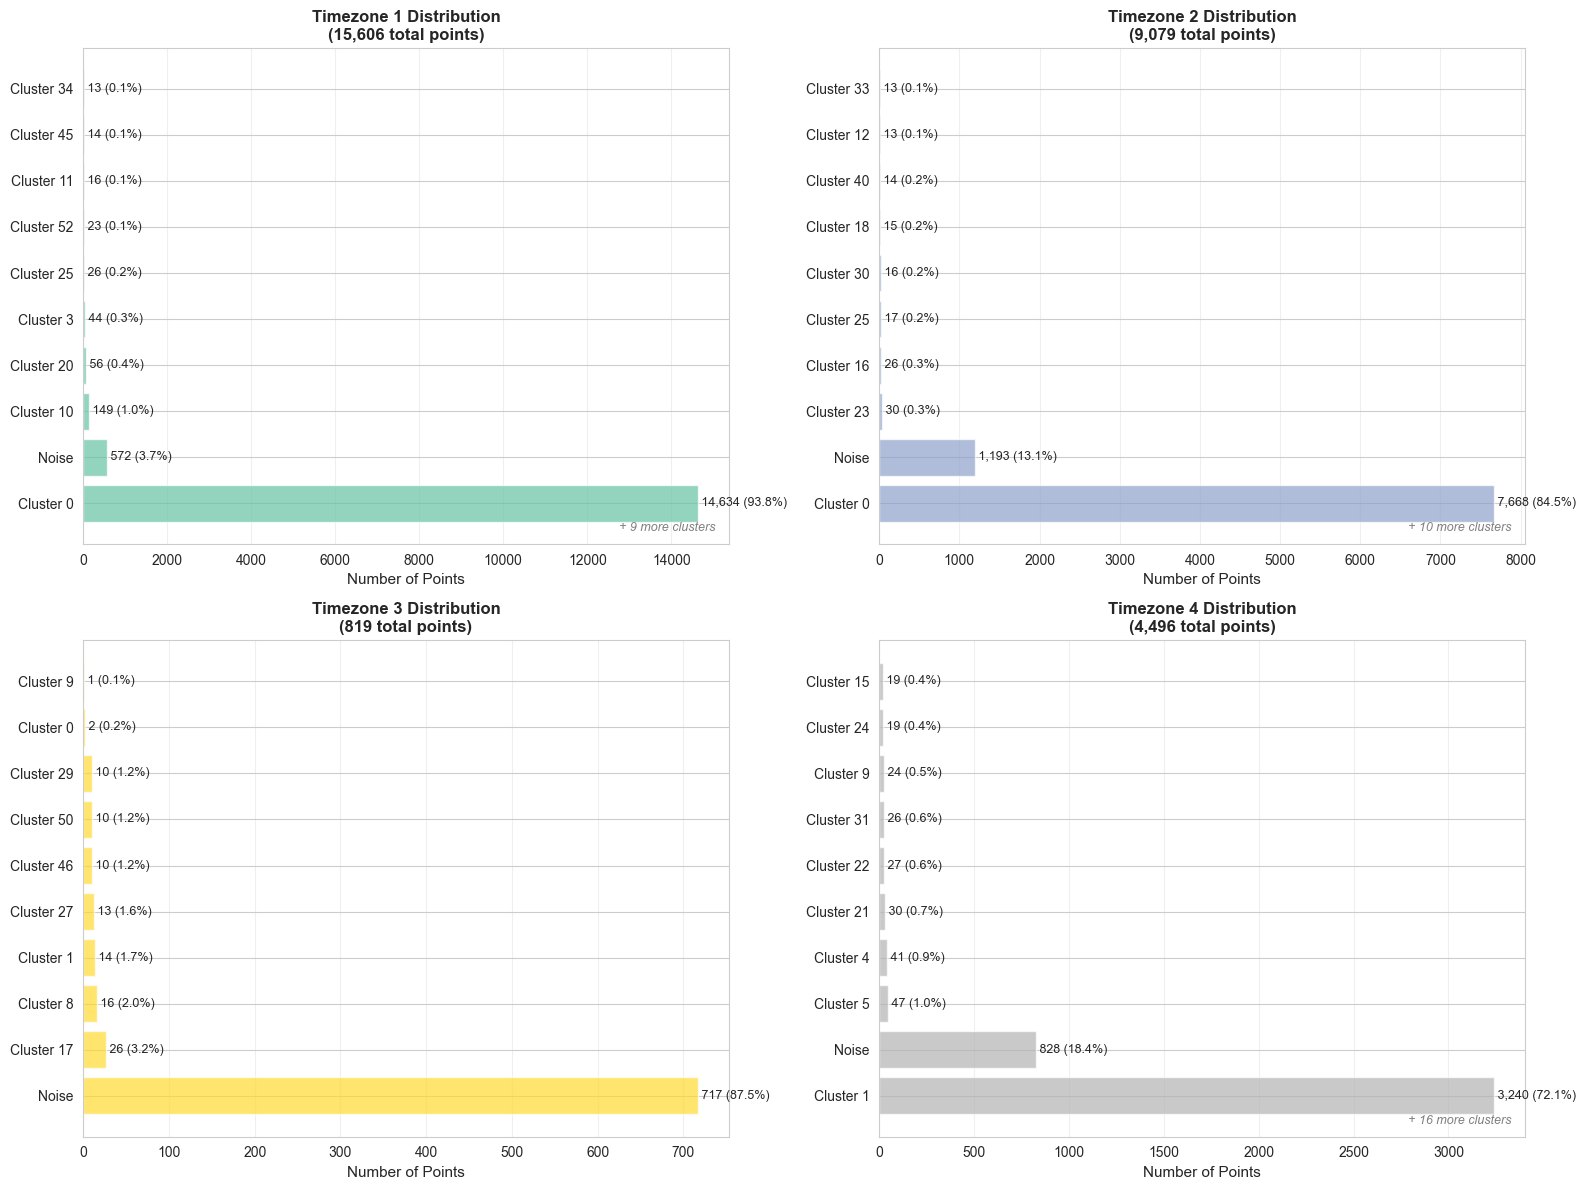


📊 INTERPRETATION:
Each subplot shows how points from ONE timezone are distributed
across the DBSCAN clusters. Ideally, each timezone would map to
one cluster, but the variable density causes fragmentation.


In [21]:
# Better visualization: Show how each timezone is distributed across clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

timezones = sorted(twitter['timezone'].unique())
colors = plt.cm.Set2(np.linspace(0, 1, len(timezones)))

for idx, tz in enumerate(timezones):
    ax = axes[idx]
    
    # Get data for this timezone
    tz_data = twitter[twitter['timezone'] == tz]
    
    # Get cluster distribution (top 10 clusters)
    cluster_dist = tz_data['cluster_best'].value_counts().head(10)
    
    # Create labels
    labels = []
    for c in cluster_dist.index:
        if c == -1:
            labels.append('Noise')
        else:
            labels.append(f'Cluster {c}')
    
    # Create bar plot
    bars = ax.barh(range(len(cluster_dist)), cluster_dist.values, color=colors[idx], alpha=0.7)
    ax.set_yticks(range(len(cluster_dist)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Number of Points', fontsize=11)
    ax.set_title(f'Timezone {tz} Distribution\n({len(tz_data):,} total points)', 
                fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, cluster_dist.values)):
        ax.text(val, i, f' {val:,} ({val/len(tz_data)*100:.1f}%)', 
               va='center', fontsize=9)
    
    # Show if there are more clusters
    if len(tz_data['cluster_best'].unique()) > 10:
        n_more = len(tz_data['cluster_best'].unique()) - 10
        ax.text(0.98, 0.02, f'+ {n_more} more clusters', 
               transform=ax.transAxes, ha='right', va='bottom',
               fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETATION:")
print("=" * 70)
print("Each subplot shows how points from ONE timezone are distributed")
print("across the DBSCAN clusters. Ideally, each timezone would map to")
print("one cluster, but the variable density causes fragmentation.")
print("=" * 70)